In [1]:
import pandas as pd
import numpy as np
import arxivscraper

#### Make authors, papers and authors_paper

In [20]:
if False:
    # Getting data computer science session
    scraper_cs = arxivscraper.Scraper(category='cs', date_from='2015-08-23',date_until='2017-08-23')
    output = scraper_cs.scrape()
    df = pd.DataFrame.from_dict(output)
    
    # Getting data stat session
    scraper_stat = arxivscraper.Scraper(category='stat', date_from='2015-08-23',date_until='2017-08-23')
    outputs = scraper_stat.scrape()
    df2 = pd.DataFrame.from_dict(outputs)
    
    # generate authors
    from random import randint
    authors = []

    output = output[0:len(outputs)]
    for aut in output:
        for i, a in enumerate(aut['authors']):
            authors.append({'idauthor': f'aoz{(i + randint(1,21)*5)}xyz{(i + randint(1,21))}', 'name': a})

    for aut in outputs:
        for i, a in enumerate(aut['authors']):
            authors.append({'idauthor': f'aoz{(i + randint(1,21)*5)}xyz{(i + randint(1,21))}', 'name': a})

    authors
    
    #Generate papers
    papers = []

    for aut in output:
        papers.append({'idpaper': aut['id'], 'title': aut['title'], 'abstract': aut['abstract'], 'date_create': aut['created'], 'area': aut['categories'], 'authors': aut['authors']})

    for aut in outputs:
        papers.append({'idpaper': aut['id'], 'title': aut['title'], 'abstract': aut['abstract'], 'date_create': aut['created'], 'area': aut['categories'], 'authors': aut['authors']})

    papers
    
    # Generate authors_paper
    autor_paper = []

    for p in papers:
        for a in authors:
            if a['name'] in p['authors']:
                autor_paper.append({'idauthor_paper': f'auz{(i + randint(1,21)*5)}ppr{(i + randint(1,21))}', 'author_idauthor': a['idauthor'], 'paper_idpaper': p['idpaper'], 'date_create': p['date_create']})
    autor_paper
    
    # Save .json files
    import json
    with open('../datasets/authors.json', 'w') as fp:
        json.dump(authors, fp)

    with open('../datasets/papers.json', 'w') as fp:
        json.dump(papers, fp)

    with open('../datasets/author_paper.json', 'w') as fp:
        json.dump(autor_paper, fp)

#### Download dataset

In [21]:
if False:
    !wget https://www.dropbox.com/s/s5mysx0b6sp7jvw/authors.json -P ../datasets/
    !wget https://www.dropbox.com/s/ktvn3q2ijfka9zn/authors_paper.json -P ../datasets/
    !wget https://www.dropbox.com/s/jbqvl5htdv41c33/papers.json -P ../datasets/

#### Load dataframes authors

In [13]:
df_authors = pd.read_json('../datasets/authors.json')
df_authors.head()

,idauthor,name
0,aoz95xyz2,chatzigeorgiou
1,aoz31xyz9,rodrigues
2,aoz97xyz6,wassell
3,aoz18xyz8,carrasco
4,aoz35xyz18,agarwal


#### Load dataframes author_paper

In [14]:
df_author_paper = pd.read_json('../datasets/authors_paper.json')
df_author_paper.head()

,author_idauthor,date_create,idauthor_paper,paper_idpaper
0,aoz95xyz2,2007-04-03,auz62ppr23,0704.0361
1,aoz31xyz9,2007-04-03,auz52ppr20,0704.0361
2,aoz97xyz6,2007-04-03,auz17ppr11,0704.0361
3,aoz18xyz8,2007-04-03,auz42ppr12,0704.0361
4,aoz7xyz18,2007-04-03,auz47ppr3,0704.0361


#### Load dataframes author_paper

In [16]:
df_paper = pd.read_json('../datasets/papers.json')
df_paper.drop(columns=['authors'], axis=1, inplace=True)
df_paper.head()

,abstract,area,date_create,idpaper,title
0,it has been observed that particular rate-1/2 ...,cs.it math.it,2007-04-03,0704.0361,pseudo-random puncturing: a technique to lower...
1,we present an algorithm for systematic encodin...,cs.it math.it,2007-04-04,0704.0590,a low complexity algorithm and architecture fo...
2,the problem of statistical learning is to cons...,cs.it cs.lg math.it,2007-04-04,0704.0671,learning from compressed observations
3,it has been shown that a decentralized relay s...,cs.it math.it,2007-04-05,0704.0805,opportunistic relay selection with limited fee...
4,this paper presents an experimental study and ...,cs.cr,2007-04-06,0704.0858,lessons learned from the deployment of a high-...


#### Extract features with LSA from abstract 

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib

In [29]:
tfidf_vectorizer = TfidfVectorizer(max_features=50000, stop_words="english", use_idf=True, smooth_idf=True)
X = tfidf_vectorizer.fit_transform(df_paper['abstract'])

models = '../models/'

with open(f'{models}tf_idf_vectorize.pkl', 'wb') as mtfidf:
    joblib.dump(tfidf_vectorizer, mtfidf)

svd = TruncatedSVD(n_components=400, algorithm='randomized',
                   n_iter=10)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
lsa.fit_transform(X)

with open(f'{models}lsa.pkl', 'wb') as fin:
    joblib.dump(lsa, fin)

tf_idf = joblib.load(f'{models}tf_idf_vectorize.pkl')

tf_idf_features = tf_idf.transform(df_paper['abstract'])

lsa = joblib.load(f'{models}lsa.pkl')

X = lsa.transform(tf_idf_features)

In [30]:
X

array([[ 0.21674655,  0.18922242, -0.12262973, ...,  0.01493392,
        -0.00791793, -0.0967814 ],
       [ 0.23906163,  0.14187788, -0.03812332, ...,  0.0163129 ,
        -0.05034635,  0.01221525],
       [ 0.31735205,  0.00455634, -0.18829676, ..., -0.05712361,
        -0.01874647,  0.05857213],
       ..., 
       [ 0.22767247, -0.09382586,  0.12284094, ...,  0.03455088,
         0.01049737,  0.03729043],
       [ 0.27161014, -0.10913158,  0.00731089, ..., -0.04656109,
        -0.01484794,  0.07930999],
       [ 0.28558632,  0.02662432,  0.1199473 , ...,  0.04327924,
        -0.01616001,  0.01764955]])

#### Clustering K-MEANS Sklearn

In [33]:
def kmeans(data):    
    from sklearn.cluster import KMeans
    %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns; sns.set()

    model = KMeans(n_clusters=2, verbose=False)
    model.fit(data)

    y_kmeans = model.predict(data)
        
    plt.scatter(data[:, 0], data[:, 1], c=y_kmeans, s=50, cmap='viridis')

    centers = model.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

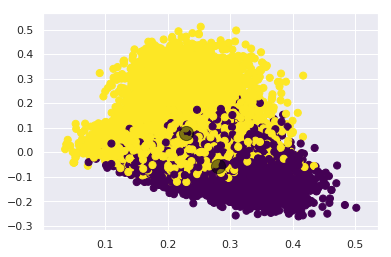

In [34]:
kmeans(X)